<a href="https://colab.research.google.com/github/PanagiotisPetrid/ASTRO-BEAM-PanagiotisPetridis/blob/main/Autoencoder_assisted_spectral_line_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Run this block to import the necessary dependencies
!pip install torch torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Create the spectral line with the added gaussian noise

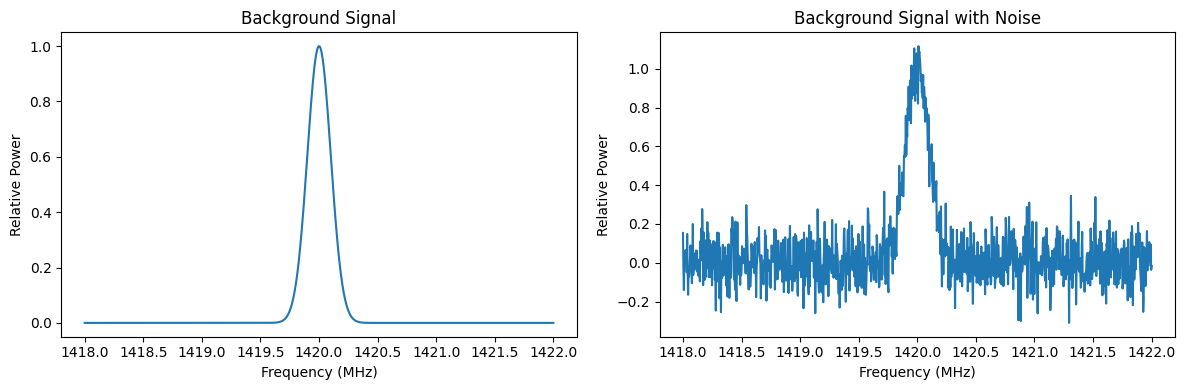

In [ ]:
# Signal parameters
n_samples = 1000  # Number of sample measurements
freq_range = np.linspace(1418, 1422, n_samples)  # Frequencies of the signal (with a bandwidth of 4 MHz)

# Add the spectral line at 1420 MHz
spectral_line_shape = np.exp(-0.5 * ((freq_range - 1420) / 0.1)**2)

# Generate noise with μ = 0, σ = 0.1
noise = np.random.normal(0, 0.1, len(spectral_line_shape))

# Add the noise to the background signal
signal = spectral_line_shape + noise

# Plot the signals for better visualization
# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the signal without the noise
axs[0].plot(freq_range, spectral_line_shape)
axs[0].set_title("Background Signal")
axs[0].set_xlabel("Frequency (MHz)")
axs[0].set_ylabel("Relative Power")

# Plot the  signal with the added gaussian noise
axs[1].plot(freq_range, signal)
axs[1].set_title("Background Signal with Noise")
axs[1].set_xlabel("Frequency (MHz)")
axs[1].set_ylabel("Relative Power")

# Show the plots
plt.tight_layout()
plt.show()

#Create the training dataset

Explaining the comments and the choices made in the code:
- `# Convert to PyTorch tensors` - A torch.tensor is a multi-dimensional matrix containing elements of a single data type. We convert the data into a PyTorch tensor in order to feed this data into PyTorch models, such as our autoencoder, and use it for forward passes, training, and evaluation.
- `torch.float32` - It means that each element in the tensor will be stored as a 32-bit floating point number (a common data type for numeric operations in neural networks).
It ensures that the data is in a format suitable for floating-point computations, which is critical for training neural networks in PyTorch since most deep learning operations work with floating point numbers.
- `# Batch size` - Batch size is a hyperparameter that defines the number of samples for the autoencoder to work through before updating internal model parameters

In [3]:
# Signal parameters
n_samples = 1000  # Number of sample measurements
freq_range = np.linspace(1418, 1422, n_samples)  # Frequencies of the signal (with a bandwidth of 4 MHz)

# We defined a function to generate a clean spectral line signal (without noise)
def generate_clean_signal(n_samples):
    freq_range = np.linspace(1418, 1422, n_samples)
    spectral_line_shape = np.exp(-0.5 * ((freq_range - 1420) / 0.1)**2)
    return spectral_line_shape

# We define a function to generate a signal with a spectral line shape and added gaussian noise
def generate_signal_with_spectral_line(n_samples):
    freq_range = np.linspace(1418, 1422, n_samples)
    spectral_line_shape = np.exp(-0.5 * ((freq_range - 1420) / 0.1)**2)
    noise = np.random.normal(0, 0.1, len(spectral_line_shape))
    signal = spectral_line_shape + noise
    return signal

# Generate a dataset of signals with spectral lines
n_signals = 1000  # Number of signals to generate
signals = np.array([generate_signal_with_spectral_line(n_samples) for _ in range(n_signals)])

# Convert to PyTorch tensors
signals_tensor = torch.tensor(signals, dtype=torch.float32)

# Create a DataLoader for batching
batch_size = 64 # Batch size
dataset = TensorDataset(signals_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#Define the autoencoder

Comments:
- `nn.Module` is the base class for all neural networks in PyTorch.
- `ReLU (nn.ReLU())` - This is a popular activation function that introduces non-linearity into the model (Activation functions are essential in neural networks as they determine the output of a node given an input or set of inputs). It helps to handle complex data distributions and makes the model more powerful. The **Rectified Linear Unit** (ReLU) is one of the most widely used activation functions in deep learning. The ReLU function is defined as: **ReLU(x) = max(0, x)**. This means that if the input x is positive, the output will be x. If the input x is negative, the output will be 0.
- `nn.Linear(n_samples, 512)` - The first layer takes in the input (which has n_samples data points) and reduces it to 512 neurons.
- `nn.Linear(512, 128)` - This second layer further compresses the 512 neurons down to 128 neurons.
- `nn.Linear(128, 32)` - The final layer compresses the 128 neurons down to 32 neurons, which is the **latent space representation**. This is where the most significant compression occurs.
- `nn.Sigmoid()` - The **sigmoid activation function** outputs values between 0 and 1. This is useful if you expect the output signal values to be normalized within this range. It introduces non-linearity and is particularly useful for making sure the output remains within a specific range.

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: Compress the input
        self.encoder = nn.Sequential(
            nn.Linear(n_samples, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        # Decoder: Reconstruct the input
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, n_samples),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x) # The input data (x) is passed through the encoder, compressing it
        decoded = self.decoder(encoded) # The compressed representation is passed through the decoder to reconstruct the original signal
        return decoded

# Initialize the autoencoder
autoencoder = Autoencoder()

#Define the training loop

We then have to define the **loss function** and the **optimizer** we will use in our autoencoder, in order to create the training loop.
 - For the **loss function** we use the **Mean Squared Error** function, a popular loss function used in regression tasks that measures the average squared differences between predicted and actual values.
 - For the **optimizer** we use the **ADAM optimizer**. Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient. Intuitively, it is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm.

We have to consider the **number of epochs** for the best training of the autoencoder. Generally speaking, the number of epochs will change if the dataset is bigger.
 - The number of epochs should not be decided a-priori. We should run the training and monitor the training and validation losses over time and stop training when the validation loss reaches a plateau or starts increasing. This technique is called "**early stopping**" and is a good practice in machine learning.


Epoch [1/50], Loss: 0.0137
Epoch [2/50], Loss: 0.0121
Epoch [3/50], Loss: 0.0116
Epoch [4/50], Loss: 0.0112
Epoch [5/50], Loss: 0.0115
Epoch [6/50], Loss: 0.0112
Epoch [7/50], Loss: 0.0111
Epoch [8/50], Loss: 0.0112
Epoch [9/50], Loss: 0.0112
Epoch [10/50], Loss: 0.0113
Epoch [11/50], Loss: 0.0112
Epoch [12/50], Loss: 0.0113
Epoch [13/50], Loss: 0.0112
Epoch [14/50], Loss: 0.0111
Epoch [15/50], Loss: 0.0113
Epoch [16/50], Loss: 0.0112
Epoch [17/50], Loss: 0.0111
Epoch [18/50], Loss: 0.0113
Epoch [19/50], Loss: 0.0112
Epoch [20/50], Loss: 0.0113
Epoch [21/50], Loss: 0.0111
Epoch [22/50], Loss: 0.0112
Epoch [23/50], Loss: 0.0112
Epoch [24/50], Loss: 0.0112
Epoch [25/50], Loss: 0.0112
Epoch [26/50], Loss: 0.0111
Epoch [27/50], Loss: 0.0107
Epoch [28/50], Loss: 0.0102
Epoch [29/50], Loss: 0.0101
Epoch [30/50], Loss: 0.0100
Epoch [31/50], Loss: 0.0100
Epoch [32/50], Loss: 0.0100
Epoch [33/50], Loss: 0.0099
Epoch [34/50], Loss: 0.0101
Epoch [35/50], Loss: 0.0099
Epoch [36/50], Loss: 0.0100
E

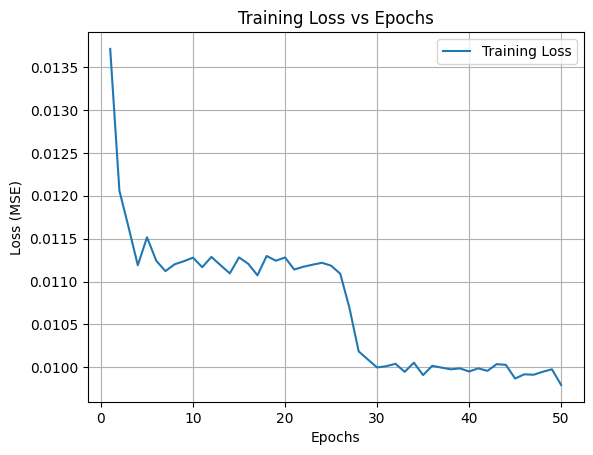

In [5]:
# Loss function (Mean Squared Error) and optimizer (Adam)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Number of epochs
n_epochs = 50

# List to store the loss values for each epoch
loss_values = []

# Training the autoencoder
for epoch in range(n_epochs):
    for data in dataloader:
        signals = data[0]  # Get the signals batch

        # Forward pass: autoencoder's prediction
        reconstructed = autoencoder(signals)

        # Compute the loss (reconstruction error)
        loss = criterion(reconstructed, signals)

        # Backpropagation and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Backpropagate the error
        optimizer.step()       # Update the weights

    # Store the loss for each epoch
    loss_values.append(loss.item())

    # Print loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

# Plot the loss versus epochs
plt.plot(range(1, n_epochs + 1), loss_values, label='Training Loss')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.legend()
plt.show()

#Autoencoder testing and results visualization

<ipython-input-10-f9a21011ec9d>:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_right = plt.subplot2grid((2, 3), (0, 2), rowspan=2)


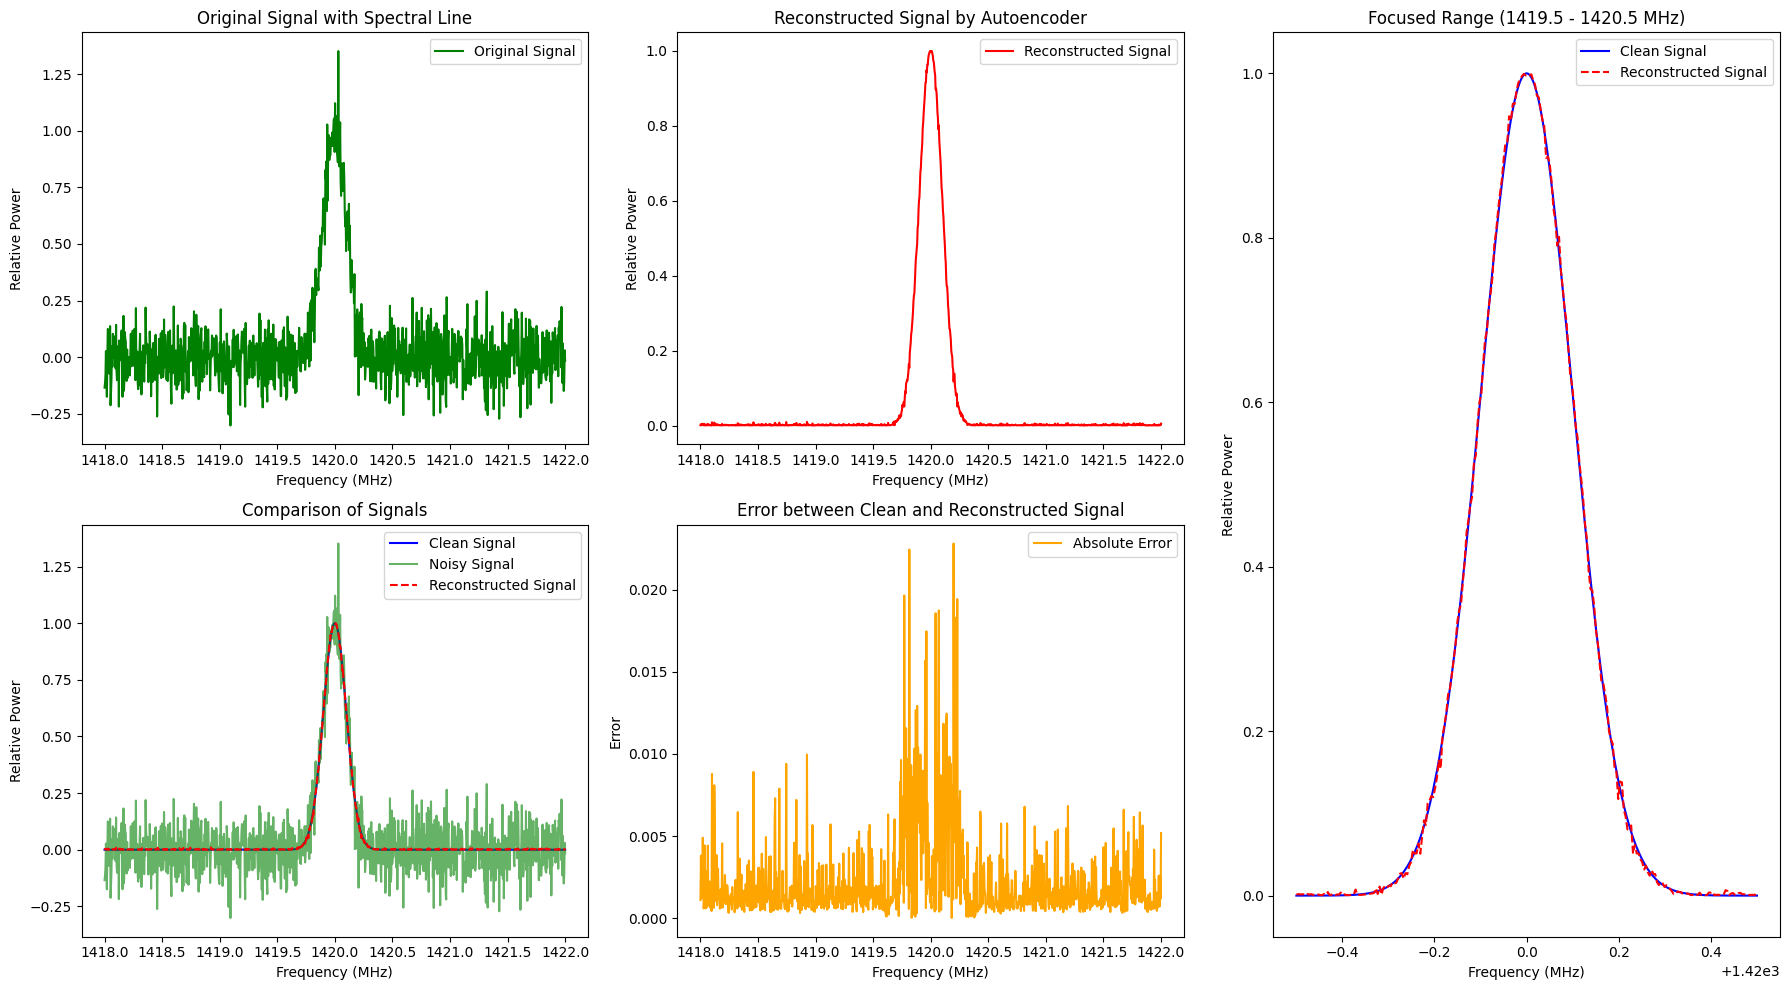

Mean Squared Error (MSE): 0.000013
Mean Absolute Error (MAE): 0.002272


In [10]:
# Test the autoencoder with a sample signal
sample_signal = generate_signal_with_spectral_line(n_samples)
sample_signal_tensor = torch.tensor(sample_signal, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Pass the signal through the autoencoder
with torch.no_grad():
    reconstructed_signal = autoencoder(sample_signal_tensor).squeeze(0).numpy()

# Generate clean signal without noise for comparison
clean_signal = generate_clean_signal(n_samples)

# Compute MSE and MAE between clean signal and reconstructed signal
mse = mean_squared_error(clean_signal, reconstructed_signal)
mae = mean_absolute_error(clean_signal, reconstructed_signal)

# Compute the error (absolute difference)
error = np.abs(clean_signal - reconstructed_signal)

# Define the focus range
focus_range_mask = (freq_range >= 1419.5) & (freq_range <= 1420.5)
focused_freq_range = freq_range[focus_range_mask]
focused_clean_signal = clean_signal[focus_range_mask]
focused_reconstructed_signal = reconstructed_signal[focus_range_mask]

# Create the subplots in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Upper left plot: Original Signal with Spectral Line
axs[0, 0].plot(freq_range, sample_signal, label='Original Signal', color='green')
axs[0, 0].set_title('Original Signal with Spectral Line')
axs[0, 0].set_xlabel('Frequency (MHz)')
axs[0, 0].set_ylabel('Relative Power')
axs[0, 0].legend()

# Upper middle plot: Reconstructed Signal by Autoencoder
axs[0, 1].plot(freq_range, reconstructed_signal, label='Reconstructed Signal', color='red')
axs[0, 1].set_title('Reconstructed Signal by Autoencoder')
axs[0, 1].set_xlabel('Frequency (MHz)')
axs[0, 1].set_ylabel('Relative Power')
axs[0, 1].legend()

# Down left plot: Comparison of Clean, Noisy, and Reconstructed Signal
axs[1, 0].plot(freq_range, clean_signal, label='Clean Signal', color='blue')
axs[1, 0].plot(freq_range, sample_signal, label='Noisy Signal', color='green', alpha=0.6)
axs[1, 0].plot(freq_range, reconstructed_signal, label='Reconstructed Signal', color='red', linestyle='dashed')
axs[1, 0].set_title('Comparison of Signals')
axs[1, 0].set_xlabel('Frequency (MHz)')
axs[1, 0].set_ylabel('Relative Power')
axs[1, 0].legend()

# Down middle plot: Absolute Error between Clean and Reconstructed Signal
axs[1, 1].plot(freq_range, error, label='Absolute Error', color='orange')
axs[1, 1].set_title('Error between Clean and Reconstructed Signal')
axs[1, 1].set_xlabel('Frequency (MHz)')
axs[1, 1].set_ylabel('Error')
axs[1, 1].legend()

# Right-side plot: Focused Clean vs Reconstructed Signal (Zoomed in 1419.5 - 1420.5 MHz for better visualization)
ax_right = plt.subplot2grid((2, 3), (0, 2), rowspan=2)
ax_right.plot(focused_freq_range, focused_clean_signal, label='Clean Signal', color='blue')
ax_right.plot(focused_freq_range, focused_reconstructed_signal, label='Reconstructed Signal', color='red', linestyle='dashed')
ax_right.set_title('Focused Range (1419.5 - 1420.5 MHz)')
ax_right.set_xlabel('Frequency (MHz)')
ax_right.set_ylabel('Relative Power')
ax_right.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Print error metrics
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")